In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

C:\Users\Conor\Anaconda3\python.exe
3.6.8 |Anaconda custom (64-bit)| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

# Home-PC

In [ ]:
import os.path

file_place = r"C:\Users\C\OneDrive"

Breast_DF = pd.read_pickle(os.path.join(file_place,"Breast_data_raw"))

In [7]:
import os.path

file_place = r"C:\Users\Conor\DataSets"

Breast_DF = pd.read_pickle(os.path.join(file_place,"Breast_data_raw"))

In [8]:
Breast_DF.head()

912   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.094676   
                                                              B4    0.094676   
                                                              B4    0.095110   
                                                              B4    0.095979   
                                                              B4    0.097282   

                                                                        916   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.093373   
                                                              B4    0.093808   
                                                              B4    0.093808   
                                                              B4    0.095110   
                                                              B4    0.095979   

                                                                        920   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.095110   
                                                              B4    0.095110   
                                                              B4    0.095545   
                                                              B4    0.096848   
                                                              B4    0.097716   

                                                                        924   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.095545   
                                                              B4    0.095545   
                                                              B4    0.095979   
                                                              B4    0.097282   
                                                              B4    0.099019   

                                                                        928   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.096848   
                                                              B4    0.096848   
                                                              B4    0.097282   
                                                              B4    0.098151   
                                                              B4    0.099888   

                                                                        932   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.097282   
                                                              B4    0.097282   
                                                              B4    0.097716   
                                                              B4    0.099019   
                                                              B4    0.100322   

                                                                        936   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.095979   
                                                              B4    0.096848   
                                                              B4    0.096848   
                                                              B4    0.097716   
                                                              B4    0.099019   

                                                                        940   \
Sex Type      Stage Pathology                 Grade Label Age Cor

# Preprocessing

Preprocessing method, maybe make this all one pipe?

In [103]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler

steps = [
         #("Normalise", Normalizer(norm = "l1"))
         ("RobustScaler", RobustScaler())
        ]

pipe  = Pipeline(steps)

In [108]:
import Tissue_Analysis_Tools as TAT

PCA_NR_Components = 50

dataframe = TAT.process_data(Breast_DF, paraffin = (1340,1490), balance = "Type")

PCA_reduced = TAT.PCA_denoise(dataframe, PCA_NR_Components)

values = pipe.fit_transform(PCA_reduced.T).T

Breast_DF_P = pd.DataFrame(values, index = dataframe.index, columns = dataframe.columns)

Processing


C:\Users\Conor\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Analysis

In [109]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

le = LabelEncoder()
lb = LabelBinarizer()

DATA = Breast_DF_P.sample(10000)

y_label = "Type"

X = DATA
Y = DATA.reset_index()[y_label]
lb.fit(Y)
Y_b = lb.transform(Y)

In [106]:
X.shape

(10000, 164)

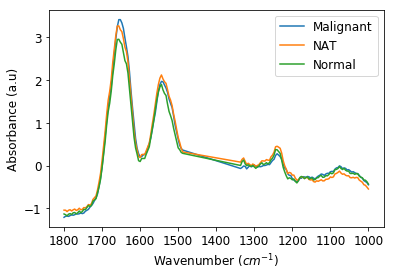

In [110]:
plt.clf()

for name, df in Breast_DF_P.groupby(level = y_label):
    
    plt.plot(df.mean(axis = 0), label = name)

plt.ylabel("Absorbance (a.u)")
plt.xlabel("Wavenumber $(cm^{-1})$")
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [111]:
param_dict = {"NAT": {'colsample_bytree': 0.5344632970043641, 'learning_rate': 0.06617275235998737, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 450, 'subsample': 0.470587311790687}
             ,"Malignant": {'colsample_bytree': 0.5874930803453049, 'learning_rate': 0.07747354115336803, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 434, 'subsample': 0.5507688768113341}
             ,"Normal": {'colsample_bytree': 0.5534332713214647, 'learning_rate': 0.06321150495968879, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 453, 'subsample': 0.5748281161442726}}

In [112]:
import xgboost as xgb

binary_classifiers = dict()

for i, name in enumerate(np.unique(Y)):

    # Find out the ratio of positive classes to negative to scale positive weights.
    # Allows for compensation of unbalanced classes without throwing away data.

    pos_ratio = 1/(np.sum(Y_b[:,i])/Y_b[:,i].shape[0])

    clf_xgb = xgb.XGBClassifier(objective = "binary:logistic", early_stopping_rounds = 10, n_classes = 2, n_jobs = -1, scale_pos_weight = pos_ratio)
    
    # Set the parameters which are best for that particular class
    clf_xgb.set_params(**param_dict[name])
    clf_xgb.fit(X,Y_b[:,i])
    
    print("Trained: {}".format(name))

    binary_classifiers[name] = clf_xgb

Trained: Malignant
Trained: NAT
Trained: Normal


# Importing Breast Cancer data

In [23]:
from sklearn.preprocessing import normalize

def import_image(original):
    
    image = original.reshape(original.shape[-1], -1)

    return normalize(image, axis = 0, norm = "l1").reshape(original.shape)

In [141]:
import os
from scipy.io import loadmat

file_place = r"B:\Breast Cancer Data\br20832_cores\br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = r"B:\Breast Cancer Data\overlay\overlay"
image_list = os.listdir(image_list_directory)

images = {file_name[:-4] : import_image(loadmat(os.path.join(file_place, file_name))["image"]) for file_name in file_list[:3]}

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'B:\\Breast Cancer Data\\br20832_cores\\br20832_cores'

In [25]:
import os
from scipy.io import loadmat

file_place = "/mnt/hgfs/E/Breast Cancer Data/br20832_cores/br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = "/mnt/hgfs/E/Breast Cancer Data/overlay/overlay"
image_list = os.listdir(image_list_directory)

images = {file_name[:-4] : import_image(loadmat(os.path.join(file_place, file_name))["image"]) for file_name in file_list[:3]}

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/mnt/hgfs/E/Breast Cancer Data/br20832_cores/br20832_cores'

In [165]:
import os
from scipy.io import loadmat
import imageio

file_place = r"E:\Breast Cancer Data\br20832_cores\br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = r"E:\Breast Cancer Data\overlay\overlay"
image_list = os.listdir(image_list_directory)

#overlays = {image_list[:-4] : imageio.imread(os.path.join(image_list_directory, image_name)) for image_name in image_list}

images = {file_name[:-4] : loadmat(os.path.join(file_place, file_name))["image"] for file_name in file_list[30:40]}

In [166]:
images.keys()

dict_keys(['B8', 'B9', 'C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16'])

# Preprocess image

In [167]:
image_ref = "C13"

image = images[image_ref]
#overlay = 

PCA_NR_Components = 100

image_dataframe = pd.DataFrame(image.reshape(-1, image.shape[-1]), columns = Breast_DF.columns)

dataframe = TAT.process_data(image_dataframe, paraffin = (1340,1490))

PCA_reduced = TAT.PCA_denoise(dataframe, PCA_NR_Components)

values = pipe.fit_transform(PCA_reduced.T).T

image_P = pd.DataFrame(values, index = dataframe.index, columns = dataframe.columns)

Processing


C:\Users\Conor\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [168]:
colours = {"Malignant": [0,0,1.0]
          ,"NAT": [1.0,0,0]
          ,"Normal": [0,1.0,0]}

In [169]:
predictions = {name: classifier.predict_proba(image_P)[:,0] for name, classifier in binary_classifiers.items()}

Pred_DF = pd.DataFrame(predictions)

Pred_DF["Winner_ID"] = Pred_DF.idxmax(axis = 1)#.map(colours)
Pred_DF["Winner_conf"] = Pred_DF.max(axis = 1)

colour_channels = Pred_DF["Winner_ID"].values.reshape(image.shape[0], image.shape[1])

new = np.array([colours[ID] for ID in colour_channels.flatten()]).reshape(image.shape[0], image.shape[1], 3)

conf = Pred_DF["Winner_conf"].values.reshape(image.shape[0], image.shape[1], 1)
rgba = np.concatenate([new,conf], axis = 2)

In [192]:
import matplotlib as mpl

def prediction_plot(image):
    
    cmaplist = list(colours.values())
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N = len(colours))
    
    fig, ax = plt.subplots()

    cax = ax.imshow(image, interpolation = None, cmap = cmap)
    cbar = fig.colorbar(cax, ticks = [0,0.5,1])
    cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar

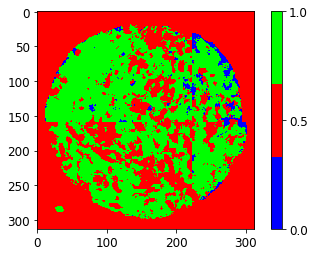

In [193]:
prediction_plot(new)

{'figure': <Figure size 432x288 with 2 Axes>, '_subplotspec': <matplotlib.gridspec.SubplotSpec object at 0x0000027BB544C828>, 'figbox': Bbox([[0.125, 0.125], [0.7450000000000001, 0.88]]), 'rowNum': 0, 'colNum': 0, 'numRows': 1, 'numCols': 2, '_stale': True, 'stale_callback': <function _stale_figure_callback at 0x0000027BC75F56A8>, '_axes': <matplotlib.axes._subplots.AxesSubplot object at 0x0000027BB2E95550>, '_transform': None, '_transformSet': False, '_visible': True, '_animated': False, '_alpha': None, 'clipbox': None, '_clippath': None, '_clipon': True, '_label': '', '_picker': None, '_contains': None, '_rasterized': None, '_agg_filter': None, '_mouseover': False, 'eventson': False, '_oid': 0, '_propobservers': {}, '_remove_method': <bound method Figure._remove_ax of <Figure size 432x288 with 2 Axes>>, '_url': None, '_gid': None, '_snap': None, '_sketch': None, '_path_effects': [], '_sticky_edges': _XYPair(x=[], y=[]), '_in_layout': True, '_position': Bbox([[0.125, 0.125], [0.745000

AttributeError: 'AxesSubplot' object has no attribute 'autoscale_None'

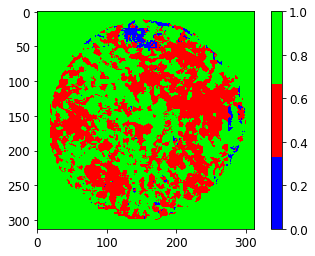

In [146]:


plt.clf()
plt.imshow(new, interpolation = None, cmap = cmap)
plt.colorbar()

print(vars(plt.gca()))
cbar = fig.colorbar(plt.gca())
plt.show()

# Plotting predictions for image

In [142]:
conf.std()

0.051670987

Original
Pre-processed
Prediction
Confidence


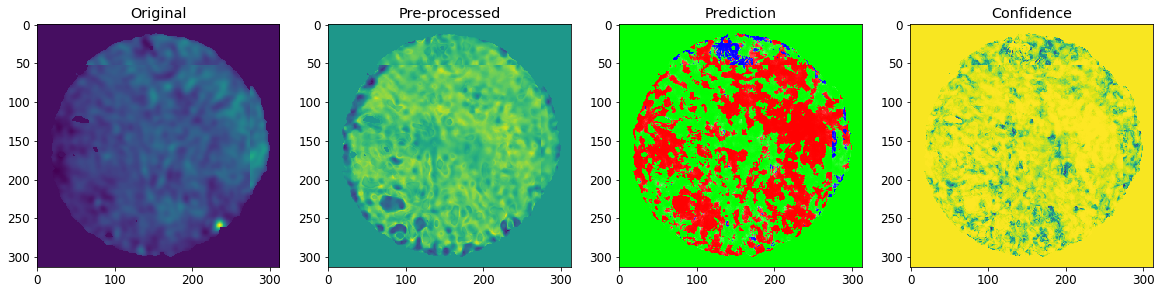

In [136]:
fig, axes = plt.subplots(ncols = 4, nrows = 1, figsize = (20,10))

titles = ["Original", "Pre-processed", "Prediction", "Confidence"]
images_ = [image.mean(axis = 2)
          , image_P.values.reshape(image.shape[0], image.shape[1],-1).mean(axis = 2)
          , rgba
          , conf.reshape(image.shape[0], image.shape[1])]

for title, ax, image_ in zip(titles, axes, images_):
    
ax.imshow(image_)
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_title(title)
    
plt.show()